In [1]:
import json
from tqdm import tqdm
CogKG_DIR = './CogKG_Neuro_chn/'
diagnose_data_path = CogKG_DIR + 'data/diagnose/aligned/diagnose_train.json'

In [2]:
def read_data(diagnose_data_path):
    symptoms, diseases = [],[]
    with open(diagnose_data_path, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            line = json.loads(line)
            symptoms.append(line['symptoms'])
            diseases.append(line['disease'])
    assert len(symptoms) == len(diseases)
    return (symptoms, diseases)

def process_raw_data_fpgrowth(raw_data):
    transactions = []
    for raw_feature, raw_label in zip(raw_data[0], raw_data[1]):
        item = []
        for symp, symp_value in raw_feature.items():
            if symp_value in [True, 'True']:
                item.append(symp)
        item.append(raw_label)
        transactions.append(item)
    return transactions

In [3]:
#Itemset Mining, Frequent Pattern Mining, FP-Growth
str2id_disease_path = CogKG_DIR + 'data/diagnose/aligned/disease2id.json'
dise2id = json.load(open(str2id_disease_path, 'r', encoding='utf-8'))

raw_data = read_data(diagnose_data_path)
transactions = process_raw_data_fpgrowth(raw_data)

In [4]:
def show_rules(rules, show_num=None, file=None):
    idx = 0
    if file:
        writer = csv.writer(f)
        writer.writerow(['rule','confidence'])
    for cause, effect in rules.items():
        idx += 1
        if file:
            writer.writerow([f'IF {cause} THEN {effect[0][0]}', effect[1] if effect[1] <= 1.0 else 1.0])
        if show_num is not None and idx > show_num:
            continue
        else:
            print(f'Rule-{idx}: IF {cause} THEN--> {effect[0][0]}, confidence:{effect[1] if effect[1] <= 1.0 else 1.0}')


def deredund_rule(rules):
    filter_rule = {}
    for cause, effect in rules.items():
        cause_list = list(filter_rule.keys())

        flag = False
        for i in cause_list:
            if len(set(cause) - set(i)) == 0:
                flag = True
                # print(f'cur:{cause} << {i}')
                break
        if flag:
            continue
        else:
            filter_rule[cause] = effect
    return filter_rule

def restrict_symtom(rules, symptom_list):
    filter_rule = {}
    print(symptom_list)
    for cause, effect in rules.items():
        flag = False
        for i in cause:
            if i not in symptom_list:
                flag = True
                break
        if flag:
            continue
        else:
            filter_rule[cause] = effect
    return filter_rule


def filter_rule(rules):
    disease_rule_dict = {}
    symptom_rule_dict = {}
    for cause, effect in rules.items():
        # mining rules for diseases
        if all(ele not in list(cause) for ele in list(dise2id.keys())) and any(ele in list(effect[0]) for ele in list(dise2id.keys())) and len(list(effect[0])) == 1 and len(list(cause)) > 1: # and len(list(cause)) <= 3
            disease = effect[0][0]
        # if all(ele not in list(cause) for ele in list(dise2id.keys())) and any(ele in list(effect[0]) for ele in list(dise2id.keys())) and len(set(list(effect[0])) & set(list(dise2id.keys()))) == 1 and len(list(cause)) > 1: # and len(list(cause)) <= 3
        #     disease = list(set(list(effect[0])) & set(list(dise2id.keys())))[0]     
            # if disease == '小儿支气管炎' and any(item in cause for item in ['支气管炎']) or len(set(cause)& set(['低热', '高热', '伴中度发热'])) > 1:
            #     continue
            # if disease == '小儿感冒' and any(item in cause for item in ['缺钙']) or len(set(cause)& set(['低热', '高热', '伴中度发热'])) > 1:
            #     continue
            # if disease == '小儿发热' and any(item in cause for item in ['发热']) or len(set(cause)& set(['低热', '高热', '伴中度发热'])) > 1:
            #     continue
            # if disease == '小儿消化不良' and any(item in cause for item in ['消化不良']) or len(set(cause)& set(['低热', '高热', '伴中度发热'])) > 1:
            #     continue
            # if disease == '小儿腹泻' and any(item in cause for item in ['腹泻']) or len(set(cause)& set(['低热', '高热', '伴中度发热'])) > 1:
            #     continue
            # if disease == '上呼吸道感染' and any(item in cause for item in ['上呼吸道感染']) or len(set(cause)& set(['低热', '高热', '伴中度发热'])) > 1:
            #     continue
            if len(set(cause) & set(['低热', '高热', '伴中度发热'])) > 1:
                continue
            if disease not in disease_rule_dict:
                disease_rule_dict[disease] = {}
            disease_rule_dict[disease][cause] = effect

        # mining rules for symptoms
        if all(ele not in list(effect[0]) for ele in list(dise2id.keys())) and len(list(effect[0])) == 1:
            symptom = effect[0][0]
            if any(symp in list(dise2id.keys()) for symp in cause):
                continue
            if symptom not in symptom_rule_dict:
                symptom_rule_dict[symptom] = {}
            symptom_rule_dict[symptom][cause] = effect
    return disease_rule_dict, symptom_rule_dict

In [5]:
MINI_SUPPORT = 6
MINI_CONFIDENCE = 0.9

In [6]:
import os
for i in os.listdir(CogKG_DIR + 'data/rule/disease_rule/'):
    if '_rules.csv' in i:
        os.remove( CogKG_DIR + 'data/rule/disease_rule/' + i)

# !pip install pyfpgrowth
import pyfpgrowth
import csv
# 支持率，置信度
patterns = pyfpgrowth.find_frequent_patterns(transactions, MINI_SUPPORT)
rules = pyfpgrowth.generate_association_rules(patterns, MINI_CONFIDENCE)
# print(f'patterns:{len(patterns)}')
# print(f'rules:{len(rules)}')

disease_rule_dict, symptom_rule_dict = filter_rule(rules)

for disease in disease_rule_dict:
    rules = disease_rule_dict[disease]
    # rules = deredund_rule(rules) # filter 1
    # rules = restrict_symtom(rules, list(dise2symps_filter[disease].keys())) # filter 2

    print(f'{disease}-rules_num:{len(rules)}, avg_len:{sum([len(i) for i in rules.keys()]) / len(rules)}')
    # show_rules(rules, show_num=None)

    with open(CogKG_DIR + 'data/rule/disease_rule/' + disease + '_rules.csv', 'w', encoding='utf-8', newline='') as f:
        show_rules(rules, show_num=1, file=f)

# print(f'symptom_num:{len(symptom_rule_dict)}\nsymptom_rules:{sum([len(i) for i in symptom_rule_dict.values()])}')

# cnt = 0
# for symptom in symptom_rule_dict:
#     rules = symptom_rule_dict[symptom]
#     rules = deredund_rule(rules)
#     print(f'{symptom}-rules_num:{len(rules)}')

#     if symptom not in ['C反应蛋白', '中性粒细胞', '化验', '听诊','大便常规','白细胞','红细胞','血小板','血常规','验血']:
#         if len(rules) <= 50:
#             with open('symp_rule/' + symptom + '_rules.txt', 'w') as f:
#                 show_rules(rules, show_num=0, file=f)
#                 cnt += len(rules)

# print(cnt)

小儿支气管炎-rules_num:52, avg_len:3.230769230769231
Rule-1: IF ('咳嗽', '支原体感染') THEN--> 小儿支气管炎, confidence:1.0
小儿腹泻-rules_num:7, avg_len:2.857142857142857
Rule-1: IF ('稀便', '肠炎') THEN--> 小儿腹泻, confidence:1.0
上呼吸道感染-rules_num:11, avg_len:2.6363636363636362
Rule-1: IF ('咽喉不适', '咽喉炎') THEN--> 上呼吸道感染, confidence:1.0
小儿消化不良-rules_num:2, avg_len:2.0
Rule-1: IF ('便秘', '消化不良') THEN--> 小儿消化不良, confidence:1.0


# 10-Fold Crossvalidation

In [9]:
import pyfpgrowth
import os, csv

import shutil
shutil.rmtree(CogKG_DIR + 'data/rule/disease_rule/K-fold/')
os.makedirs(CogKG_DIR + 'data/rule/disease_rule/K-fold')

str2id_disease_path = CogKG_DIR + 'data/diagnose/aligned/disease2id.json'
dise2id = json.load(open(str2id_disease_path, 'r', encoding='utf-8'))

for i in range(10):
    diagnose_data_path = CogKG_DIR + f'data/diagnose/aligned/K-fold/diag_rule_fold_{i}.json'
    # print(diagnose_data_path)
    raw_data = read_data(diagnose_data_path)
    transactions = process_raw_data_fpgrowth(raw_data)
    patterns = pyfpgrowth.find_frequent_patterns(transactions, MINI_SUPPORT)
    rules = pyfpgrowth.generate_association_rules(patterns, MINI_CONFIDENCE)
    disease_rule_dict, symptom_rule_dict = filter_rule(rules)

    k_fold_dir = CogKG_DIR + f'data/rule/disease_rule/K-fold/fold-{i}'
    if not os.path.exists(k_fold_dir):
        os.makedirs(k_fold_dir)

    for disease in disease_rule_dict:
        rules = disease_rule_dict[disease]

        print(f'{disease}-rules_num:{len(rules)}, avg_len:{sum([len(i) for i in rules.keys()]) / len(rules)}')
        # show_rules(rules, show_num=None)

        with open(k_fold_dir + '/' + disease + '_rules.csv', 'w', encoding='utf-8', newline='') as f:
            show_rules(rules, show_num=1, file=f)


小儿支气管炎-rules_num:43, avg_len:3.2325581395348837
Rule-1: IF ('咳嗽', '支原体感染') THEN--> 小儿支气管炎, confidence:1.0
小儿腹泻-rules_num:10, avg_len:3.1
Rule-1: IF ('水样便', '肠炎') THEN--> 小儿腹泻, confidence:1.0
上呼吸道感染-rules_num:18, avg_len:2.888888888888889
Rule-1: IF ('咽喉不适', '咽喉炎') THEN--> 上呼吸道感染, confidence:1.1428571428571428
小儿消化不良-rules_num:1, avg_len:2.0
Rule-1: IF ('便秘', '排气') THEN--> 小儿消化不良, confidence:1.0
小儿支气管炎-rules_num:54, avg_len:3.2777777777777777
Rule-1: IF ('咳嗽', '气管炎') THEN--> 小儿支气管炎, confidence:1.0
小儿腹泻-rules_num:11, avg_len:3.1818181818181817
Rule-1: IF ('水样便', '肠炎') THEN--> 小儿腹泻, confidence:1.0
上呼吸道感染-rules_num:18, avg_len:2.9444444444444446
Rule-1: IF ('发热', '咽喉不适', '高热') THEN--> 上呼吸道感染, confidence:1.2
小儿消化不良-rules_num:1, avg_len:2.0
Rule-1: IF ('便秘', '排气') THEN--> 小儿消化不良, confidence:1.0
小儿支气管炎-rules_num:56, avg_len:3.3392857142857144
Rule-1: IF ('咳嗽', '支原体感染') THEN--> 小儿支气管炎, confidence:1.0
小儿腹泻-rules_num:9, avg_len:3.2222222222222223
Rule-1: IF ('稀便', '肠炎') THEN--> 小儿腹泻, confidence:

# Incremental Setting

In [7]:
# import pyfpgrowth
# import os, csv

# str2id_disease_path = CogKG_DIR + 'data/diagnose/aligned/disease2id.json'
# dise2id = json.load(open(str2id_disease_path, 'r', encoding='utf-8'))

# for dise in dise2id:
#     diagnose_data_path = CogKG_DIR + f'data/diagnose/aligned/IncreSetting/diagnose_inven_{dise}.json'
#     # print(diagnose_data_path)

#     raw_data = read_data(diagnose_data_path)
#     transactions = process_raw_data_fpgrowth(raw_data)
#     patterns = pyfpgrowth.find_frequent_patterns(transactions, 5)
#     rules = pyfpgrowth.generate_association_rules(patterns, 0.5)
#     disease_rule_dict, symptom_rule_dict = filter_rule(rules)

#     incre_fold_dir = CogKG_DIR + f'data/rule/disease_rule/IncreSetting/{dise}_as_incre/'
#     if not os.path.exists(incre_fold_dir):
#         os.makedirs(incre_fold_dir)

#     for disease in disease_rule_dict:
#         rules = disease_rule_dict[disease]

#         print(f'{disease}-rules_num:{len(rules)}, avg_len:{sum([len(i) for i in rules.keys()]) / len(rules)}')
#         # show_rules(rules, show_num=None)

#         with open(incre_fold_dir + disease + '_rules.csv', 'w', encoding='utf-8') as f:
#             show_rules(rules, show_num=1, file=f)

(7, 7)


/tmp/ipykernel_99752/1566198832.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, auto_add_to_figure=True)


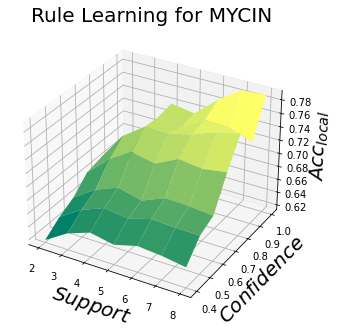

In [180]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 创建 3D 图形对象
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=True)

# 生成数据
X = np.arange(-2, 2, 0.1)
Y = np.arange(-2, 2, 0.1)
X, Y = np.meshgrid(X, Y)
Z = np.sqrt(X ** 2 + Y ** 2)

X, Y = np.meshgrid([2, 3, 4, 5, 6, 7, 8],
                   [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
print(X.shape)
Z = np.asarray([
        [0.6164870292195497, 0.6379209872551379, 0.6501769572138653, 0.643104096642664, 0.6524629852819884, 0.6493186330173124, 0.643705982177041], 
        [0.6330463225971487, 0.6549135232665497, 0.6684436870893904, 0.6634006211152548, 0.6734678914150003, 0.671606228134596, 0.6708500314316035], 
        [0.6450592819316797, 0.667352849832607, 0.6810054442799498, 0.6718621629544717, 0.6860688422941589, 0.6847535555272577, 0.6814269447135443], 
        [0.6660895386441507, 0.6955697704527306, 0.7171764286036785, 0.7096446549817883, 0.7265092273936417, 0.7218748630390392, 0.7270219539675636], 
        [0.67134580958978, 0.7142600095734626, 0.7383239340535888, 0.7374681633228064, 0.7456318309093886, 0.7582920308199662, 0.7666665591840118], 
        [0.6344194571337428, 0.6916361886158464, 0.7362264697871563, 0.7293037709806927, 0.7507658927917549, 0.7497370857805641, 0.7367044817927171],
        [0.6313618990921003, 0.6872972130245106, 0.7406502052232604, 0.7350830409526062, 0.7644943995306972, 0.7879702375368011, 0.7900840336134454],
    ]) # y_dim * x_dim

# z = np.asarray([
#         [f(2,0.4), f(3,0.4), f(4,0.4), f(5,0.4), f(6,0.4), f(7,0.4), f(8,0.4)],
#         [f(2,0.5), f(3,0.5), f(4,0.5), f(5,0.5), f(6,0.5), f(7,0.5), f(8,0.5)],
#         [f(2,0.6), f(3,0.6), f(4,0.6), f(5,0.6), f(6,0.6), f(7,0.6), f(8,0.6)],
#         [f(2,0.7), f(3,0.7), f(4,0.7), f(5,0.7), f(6,0.7), f(7,0.7), f(8,0.7)],
#         [f(2,0.8), f(3,0.8), f(4,0.8), f(5,0.8), f(6,0.8), f(7,0.8), f(8,0.8)],
#         [f(2,0.9), f(3,0.9), f(4,0.9), f(5,0.9), f(6,0.9), f(7,0.9), f(8,0.9)],
#         [f(2,1.0), f(3,1.0), f(4,1.0), f(5,1.0), f(6,1.0), f(7,1.0), f(8,1.0)],
#     ]) # y_dim * x_dim

ax.set_xlabel('$Support$', fontsize=20, rotation=150)
ax.set_ylabel('$Confidence$', fontsize=20)
ax.set_zlabel(r'$Acc_{local}$', fontsize=20, rotation=60)
ax.set_title('Rule Learning for MYCIN', fontsize=20)
# 绘制曲面图，并使用 cmap 着色
ax.plot_surface(X, Y, Z, cmap=plt.cm.summer)

plt.show()